# Why do we care about uncertainty decomposition?

- epistemic and aleatoric uncertainty are reduced in different ways
- adding more training data will reduce epistemic uncertainty
- aleatoric uncertainty can be reduced by collecting more refined measurements or additional features, but *not* just with additional data points
- the goal of this notebook is to show that seeing more training points will reduce epistemic uncertainty, but not aleatoric

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from numpy import ma
from keras.layers import Input
from toolbox import load_dataset, uncertainty
from collections import defaultdict

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
_, _, test = load_dataset.load_image_data('cifar10', channels_first=False)
x_class = test[0]

# _, _, test_cifar100 = load_dataset.load_image_data('cifar100', channels_first=False)
# x_class = test_cifar100

In [3]:
max_frac = 10
results_aleatoric = defaultdict(list)
results_epistemic = defaultdict(list)
results_predictive = defaultdict(list)
results_accuracy = defaultdict(list)
runs = 3
for run in range(1, runs+1):
    for p in range(1, max_frac + 1):
        frac = '{:.1f}'.format(p/10)
        file_name = '../../models/bbalpha-train-n/saved_models_train_frac/cifar10-cnn-alpha0.5-run{}/frac{}/model-test.h5'.format(run, frac)
        test_model = load_model(file_name)
        pred_mc = test_model.predict(x_class)
        unc = uncertainty.compute_uncertainties(pred_mc)
        results_aleatoric[frac].append(np.mean(unc['aleatoric']))
        results_epistemic[frac].append(np.mean(unc['epistemic']))
        results_predictive[frac].append(np.mean(unc['predictive']))
        correct = np.argmax(unc['pred'], axis=1) == np.argmax(test[1], axis=1)
        results_accuracy[frac].append(np.mean(correct))
        print(frac)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


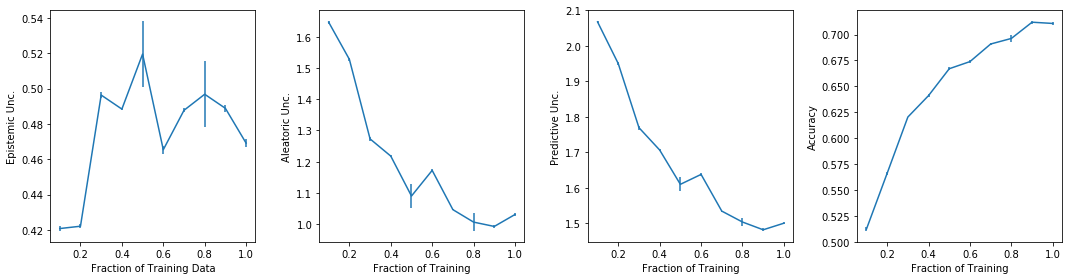

In [4]:
fracs = [p/10 for p in range(1, max_frac + 1)]
fracs_str = ['{:.1f}'.format(p/10) for p in range(1, max_frac + 1)]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
ax1.errorbar(fracs, [np.mean(results_epistemic[f]) for f in fracs_str],
             [np.std(results_epistemic[f]) for f in fracs_str])
ax1.set_xlabel("Fraction of Training Data")
ax1.set_ylabel('Epistemic Unc.')
ax2.errorbar(fracs, [np.mean(results_aleatoric[f]) for f in fracs_str],
              [np.std(results_aleatoric[f]) for f in fracs_str])
ax2.set_xlabel("Fraction of Training")
ax2.set_ylabel('Aleatoric Unc.')
ax3.errorbar(fracs, [np.mean(results_predictive[f]) for f in fracs_str],
              [np.std(results_predictive[f]) for f in fracs_str])
ax3.set_xlabel("Fraction of Training")
ax3.set_ylabel('Predictive Unc.')
ax4.errorbar(fracs, [np.mean(results_accuracy[f]) for f in fracs_str],
              [np.std(results_accuracy[f]) for f in fracs_str])
ax4.set_xlabel("Fraction of Training")
ax4.set_ylabel('Accuracy')
f.tight_layout()

In [11]:
# on run3, frac 1.0, highest pred unc examples
ind = np.argsort(unc['predictive'])[-10:]
print('Indices: {}'.format(ind))
print(unc['predictive'][ind])
# print(unc['pred'][ind, target])
print(np.max(unc['pred'][ind], axis=1))
print(unc['pred'][ind, np.argmax(test[1][ind], axis=1)])

Indices: [8463 4170 7201 9294 1696 9560  583 5198 9126 3216]
[3.0747333 3.075207  3.0800297 3.0900245 3.0927155 3.0970433 3.1433747
 3.15884   3.1748579 3.1851141]
[0.24549064 0.18873379 0.22128399 0.26434717 0.23508957 0.17290708
 0.15931752 0.21184431 0.16135278 0.17843361]
[0.11147714 0.18873379 0.04295488 0.06419024 0.23508957 0.11190763
 0.1207521  0.21184431 0.06367291 0.17843361]
